In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = pd.DataFrame(train)
test = pd.DataFrame(test)

여기서는 정량적 즉 수치로 변환가능한 데이터 항목만 다룰 예정임
그로 인해 'SAMPLE_ID','ID','ARI_CO','ARI_PO','SHIPMANAGER','FLAG' 제외

In [3]:
#data 전처리
train.drop(['SAMPLE_ID','ID','ARI_CO','ARI_PO','SHIPMANAGER','FLAG'],axis=1,inplace=True)
test.drop(['SAMPLE_ID','ID','ARI_CO','ARI_PO','SHIPMANAGER','FLAG'],axis=1,inplace=True)

In [4]:
for i in [train,test]:
    i['SHIP_TYPE_CATEGORY']=i['SHIP_TYPE_CATEGORY'].astype('category')
    i['ATA']=pd.to_datetime(i['ATA'])
    i['YEAR']=i['ATA'].dt.year
    i['MONTH']=i['ATA'].dt.month
    i['Weekday']=i['ATA'].dt.dayofweek
    i.drop(['ATA'],axis=1,inplace=True)

선종 열을 카테고리로 변경
ATA를 연,월,요일로 나눈뒤 ATA는 삭제

1) 선종 별로 모델따로 학습시킨뒤 붙히거나 아님 원핫인코딩통해 조건문으로 모델 돌리기

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   SHIP_TYPE_CATEGORY  391939 non-null  category
 1   DIST                391939 non-null  float64 
 2   BREADTH             391938 non-null  float64 
 3   BUILT               391939 non-null  int64   
 4   DEADWEIGHT          391939 non-null  int64   
 5   DEPTH               391938 non-null  float64 
 6   DRAUGHT             391938 non-null  float64 
 7   GT                  391939 non-null  int64   
 8   LENGTH              391938 non-null  float64 
 9   U_WIND              228251 non-null  float64 
 10  V_WIND              228251 non-null  float64 
 11  AIR_TEMPERATURE     227309 non-null  float64 
 12  BN                  228251 non-null  float64 
 13  ATA_LT              391939 non-null  int64   
 14  PORT_SIZE           391939 non-null  float64 
 15  CI_HOUR          

c:\Users\KSM\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


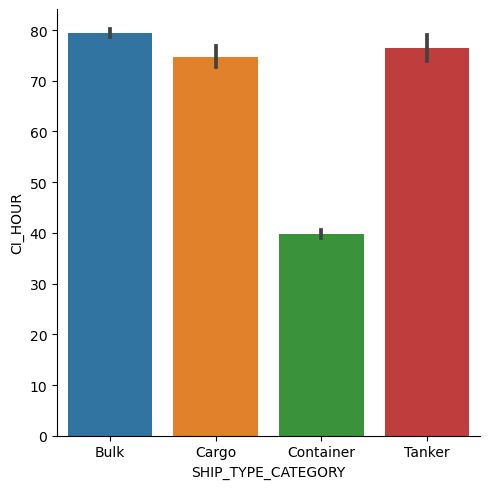

In [24]:
sns.catplot(x='SHIP_TYPE_CATEGORY',y='CI_HOUR',data=train,kind='bar')

In [5]:
train2=pd.get_dummies(train['SHIP_TYPE_CATEGORY'])

In [6]:
train3 = pd.concat([train,train2],axis=1)

1) 결측치를 평균으로
2) 결측치 제외
--모델 완성까지해보고
3) 결측치를 외부 데이터를 끌어와서 사용 ex) 특정 지역의 특정 시간 풍력벡터와 BN

요일은 주말 1, 평일은 0
월, 연 제외
built 제외

배 수치관련
상관관계가 0.8~0.9에 육박함 그래서 GT를 대표로 나머지 수치관련 항목은 일단 제외하고 수행
deadweight는 포함
하면서 조정

u,v 뺴고 제곱루트 떄려서 풍력항 하나 만들기
OR
BN만 쓰자



In [52]:
train3.columns
# 내가 돌려봤는데 DEADWEIGHT, GT보단 길이 각각 따로 넣는게 나은거같음..

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'YEAR', 'MONTH', 'Weekday', 'Bulk',
       'Cargo', 'Container', 'Tanker'],
      dtype='object')

In [7]:
train3 = train3.drop(['BUILT','SHIP_TYPE_CATEGORY','DEADWEIGHT','GT','U_WIND','V_WIND','YEAR','MONTH'],axis=1)

In [8]:
train3.columns

Index(['DIST', 'BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'AIR_TEMPERATURE',
       'BN', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'Weekday', 'Bulk', 'Cargo',
       'Container', 'Tanker'],
      dtype='object')

 결측치 처리
  https://daebaq27.tistory.com/43
 BN에 대해서는 어떻게 할것인가?
 AIR_TEMPERATURE는?
결측치 비율	처리 방법
10% 미만	제거 또는 치환
10% 이상 20% 미만	모델 기반 처리
20% 이상	모델 기반 처리

In [15]:
train3.info()
print(100*(391938 - 227308)/391938)
print(100*(391938-228250)/391938)


<class 'pandas.core.frame.DataFrame'>
Index: 391938 entries, 0 to 391938
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DIST             391938 non-null  float64
 1   BREADTH          391938 non-null  float64
 2   DEPTH            391938 non-null  float64
 3   DRAUGHT          391938 non-null  float64
 4   LENGTH           391938 non-null  float64
 5   AIR_TEMPERATURE  227308 non-null  float64
 6   BN               228250 non-null  float64
 7   ATA_LT           391938 non-null  int64  
 8   PORT_SIZE        391938 non-null  float64
 9   CI_HOUR          391938 non-null  float64
 10  Weekday          391938 non-null  int32  
 11  Bulk             391938 non-null  bool   
 12  Cargo            391938 non-null  bool   
 13  Container        391938 non-null  bool   
 14  Tanker           391938 non-null  bool   
dtypes: bool(4), float64(9), int32(1), int64(1)
memory usage: 35.9 MB
42.00409248401533
41.7637

In [20]:
train3.to_csv("train4.csv",index=False)

In [17]:
train3 = pd.read_csv('train3.csv')
train3.head()

,DIST,BREADTH,DEPTH,DRAUGHT,LENGTH,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,Weekday,Bulk,Cargo,Container,Tanker,CI_HOUR
0,30.881018,30,10,10,180,NaN,NaN,5,0.002615,0,False,False,True,False,3.450000
1,0.000000,30,10,10,180,NaN,NaN,12,0.000217,1,True,False,False,False,0.000000
2,0.000000,50,30,20,370,NaN,NaN,6,0.001614,1,False,False,True,False,0.000000
3,0.000000,20,10,10,120,6.7,2.629350,13,0.000356,4,False,False,True,False,0.000000
4,27.037650,50,20,10,300,25.6,2.495953,15,0.002615,6,False,False,True,False,253.554444


In [18]:
train3=train3.replace({True:1,False:0})

In [28]:
dist_0_count = (train3['DIST']==0).sum()
total_data = 391938
print(dist_0_count / total_data)

0.4013185758972082


dist가 0인 데이터가 너무 많음 40퍼센트..
dist가 0인 행이 결측치가 존재하면 그행은 제외하고 계산해보자

In [48]:
X=train3.drop(['CI_HOUR'],axis=1)
y=train3[['CI_HOUR']]

In [52]:
# X 결측치 채우기
from sklearn.impute import SimpleImputer

# SimpleImputer를 사용하여 결측치를 해당 열의 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [55]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ElasticNet 모델 생성 및 학습
alpha = 0.1  # L1 regularization의 계수
l1_ratio = 0.5  # L1 규제의 비율
enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
enet.fit(X_train, y_train)

# 학습된 모델을 사용하여 예측
y_pred = enet.predict(X_test)

# 모델의 성능 평가 (예시로 MSE 사용)
MAE = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", MAE)


Mean Squared Error: 71.61074083135092


1. feature 임의 확정 (배 수치 관련) - 피처 10개밖에 안되니까 복사해서 두 케이스 모두 해보는걸로
    필요하다면 feature를 만든다.
2. 결측치 처리 방안 ex) dist가 0, bn, 기온
3. 모델 선정 (각자 좀 찾아와서 다 돌려서 성능좋은걸로)
    의사결정트리회귀
    캣부스트
